<a href="https://colab.research.google.com/github/Yujini68/ESAA/blob/main/%EA%B3%BC%EC%A0%9C_0906.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CHAPTER 3 분류

## 3.1 MNIST

MNIST 데이터셋 : 고등학생과 미국 인구조사국 직원들이 손으로 쓴 70,000개의 작은 숫자이미지를 모은 것

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

- DESCR 키 : 데이터셋 설명
- data 키 : 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열
- target 키 : 레이블 배열

In [2]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

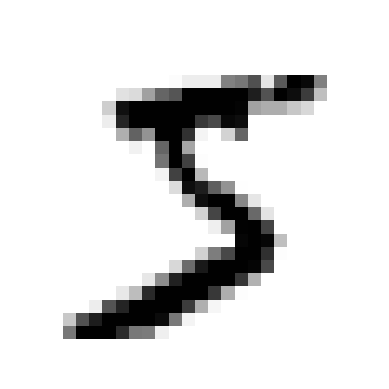

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [5]:
y[0]

'5'

In [6]:
import numpy as np
y = y.astype(np.uint8)

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 3.2 이진 분류기 훈련

이진 분류기 : 두 개의 클래스 구분

In [8]:
y_train_5 = (y_train == 5) # 5는 True고, 다른 숫자는 모두 False
y_test_5 = (y_test == 5)

확률적 경사 하강법 SGD 분류기 : 매우 큰 데이터셋 효율적 처리, 한번에 하나씩 훈련 샘플을 독립적으로 처리

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [10]:
#숫자 5 이미지 감지
sgd_clf.predict([some_digit])

array([ True])

## 3.3 성능 측정

### 3.3.1 교차 검증을 사용한 정확도 측정

- 사이킷런의 cross_val_score() 함수와 거의 같은 작업 수행, 동일한 결과 출력
- StratifiedKFold : 클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링을 수행, 매 반복에서 분류기 객체를 복제하여 훈련 폴드로 훈련시키고 테스트 폴드로 예측, 올바른 예측의 수를 세어 정확한 예측의 비율을 출력
- cross_val_score() : 함수로 폴드가 3개인 k-겹 교차 검증을 사용해 SGDClassifier 모델을 평가, k-겹 교차 검증은 훈련 세트를 k개의 폴드로 나누고, 각 폴드에 대해 예측을 만들고 평가하기 위해 나머지 폴드로 훈련시킨 모델을 사용

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds=StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf=clone(sgd_clf)
    X_train_folds=X_train[train_index]
    y_train_folds=y_train_5[train_index]
    X_test_fold=X_train[test_index]
    y_test_fold=y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred=clone_clf.predict(X_test_fold)
    n_correct=sum(y_pred==y_test_fold)
    print(n_correct/len(y_pred)) # 0.9502, 0.96565, 0.96495 출력

0.95035
0.96035
0.9604


In [12]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

- 정확도 : 정확한 예측의 비율
- 모든 교차 검증 폴드에 대해 정확도가 95% 이상

In [13]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

- 모든 이미지를 '5 아님' 클래스로 분류하는 더미 분류기 생성

In [14]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

- 이미지의 10% 정도가 숫자 5이기 때문에 무조건 '5 아님'으로 예측 시, 정확히 맞출 확률이 90%가 됨
- 정확도는 분류기의 성능 지표로 선호하지 않음(특히 불균형한 데이터셋)

# 3.3.2 오차 행렬

클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것

행: 실제 클래스

열: 예측 클래스

cross_val_predict() : k 교차 검증을 수행하지만 평가 점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측 반환

In [15]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

- 1행 1열 '53892' : 5가 아닌 이미지를 5가 아니라고 맞게 분류 -> 진짜 음성 true negative
- 1행 2열 '687' : 5가 아닌 이미지를 5라고 잘못 분류 -> 거짓 양성 false positive
- 2행 1열 '1891' : 5 이미지를 5가 아니라고 잘못 분류 -> 거짓 음성 false negative
- 2행 2열 '3530': 5 이미지를 5라고 맞게 분류 -> 진짜 양성 true positive

In [17]:
y_train_perfect_predictions = y_train_5 # 완벽한 분류기일 경우
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

완벽한 분류기 -> 오차행렬의 주대각선만 0이 아님

정밀도 : 양성 예측의 정확도 TP/(TP+FP)

재현율(민감도, 진짜 양성 비율) : 분류기가 정확하게 감지한 양성 샘플의 비율 TP/(TP+FN)

TP : 진짜 양성의 수

FP : 거짓 양성의 수

### 3.3.3 정밀도와 재현율

In [18]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1522)

0.8370879772350012

F1 점수 : 정밀도와 재현율의 조화 평균

In [19]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

정밀도를 올리면 재현율이 줄고 그 반대도 마찬가지
-> 정밀도/재현율 트레이드오프

### 3.3.4 정밀도/재현율 트레이드오프

SGDClassifier

- 결정 함수를 사용하여 각 샘플의 점수 계산 -> 임곗값보다 크면 샘플을 양성 클래스에 할당, 그렇지 않으면 음성 클래스의 할당

decision_function() : 각 샘플의 점수 -> 원하는 임곗값을 정해 예측 수행

In [20]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [21]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [22]:
#임곗값 높이기
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

임곗값 높이면 재현율 줄어들었음

cross_val_predict() : 훈련 세트에 있는 모든 샘플의 점수 구하기, 결정 점수를 반환 받도록 지정

In [23]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [24]:
from sklearn.metrics import precision_recall_curve
# 가능한 모든 임곗값에 대해 정밀도와 재현율 계산
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51076 (\N{HANGUL SYLLABLE IM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44247 (\N{HANGUL SYLLABLE GYES}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packag

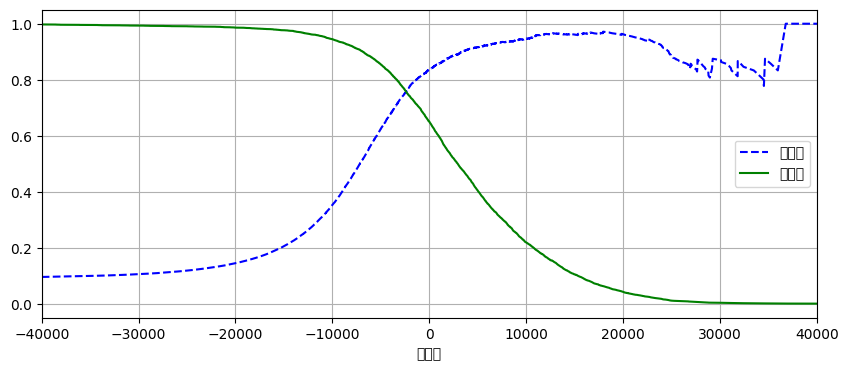

In [25]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.figure(figsize=(10,4))
  plt.plot(thresholds, precisions[:-1], "b--", label="정밀도")
  plt.plot(thresholds, recalls[:-1], "g-", label="재현율")
  plt.xlabel("임곗값")
  plt.xlim(-40000, 40000)
  plt.legend()
  plt.grid()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [26]:
# 최소한 90% 정밀도가 되는 가장 낮은 임곗값 찾기
#np.argmax(): 최댓값의 첫 번째 인덱스를 반환
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] # ~7816

In [27]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [28]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [29]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### 3.3.5 ROC 곡선
거짓 양성 비율 FPR 에 대한 진짜 양성 비율 TPR 의 곡선

양성으로 잘못 분류되 음성 샘플의 비율 FPR : 1 - 음성으로 정확하게 분류한 음성 샘플의 비율, 진짜 음성 비율 TNR(특이도)

ROC 곡선 : 민감도에 대한 1-특이도

In [30]:
#roc_curve() 함수 이용해 여러 임곗값에서 TPR, FPR 계산하기
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

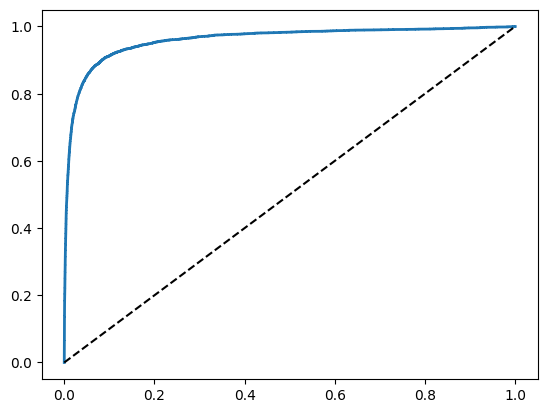

In [31]:
# TPR에 대한 FPR 곡선 나타내기
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1], [0,1], 'k--') # 대각 점선

plot_roc_curve(fpr, tpr)
plt.show()

AUC : 곡선 아래의 면적 -> 분류기들 비교

완벽한 분류기 1, 완전한 랜덤 분류기 0.5

In [32]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [33]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [34]:
y_scores_forest = y_probas_forest[:, 1] # 양성 클래스에 대한 확률을 점수로 사용합니다.
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47004 (\N{HANGUL SYLLABLE RAEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45924 (\N{HANGUL SYLLABLE DEOM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47112 (\N{HANGUL SYLLABLE RE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/

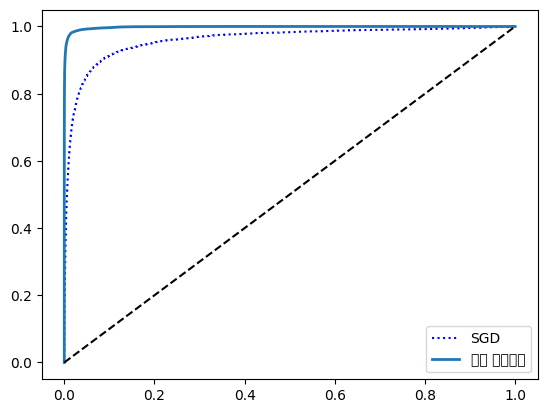

In [35]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "랜덤 포레스트")
plt.legend(loc="lower right")
plt.show()

## 3.4 다중분류

둘 이상의 클래스 구별

OvR OvA 전략 : 특정 숫자 하나만 구분하는 숫자별 이진 분류기를 훈련시켜 클래스가 10개인 숫자 이미지 분류 시스템 만들기 -> 이미지를 분류할 때 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택

OvO 전략 : 각 숫자의 조합마다 이진 분류기를 훈련 시킴, 각 분류기의 훈련에 전체 훈련 세트 중 구별할 두 클래스에 해당하는 샘플만 필요


In [36]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train[:2000], y_train[:2000])
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [37]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 3.79297828,  0.72949369,  6.06184129,  8.29800527, -0.29383983,
         9.30157597,  1.74723215,  2.77365456,  7.20601456,  4.82245092]])

In [38]:
np.argmax(some_digit_scores)

5

In [39]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [40]:
svm_clf.classes_[5]

5

In [41]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [42]:
len(ovr_clf.estimators_)

10

In [43]:
sgd_clf.fit(X_train[:2000], y_train[:2000])
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

In [44]:
sgd_clf.decision_function([some_digit])

array([[-1704540.26918897, -1683382.42678916, -2594122.50571131,
         -145667.7337014 , -3270741.36924448,    -4883.95058744,
        -3420127.24409032, -1846510.16554943, -1328858.01006284,
        -2043246.17459117]])

In [45]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

In [46]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## 3.5 에러 분석

오차 행렬 살펴보기

In [47]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

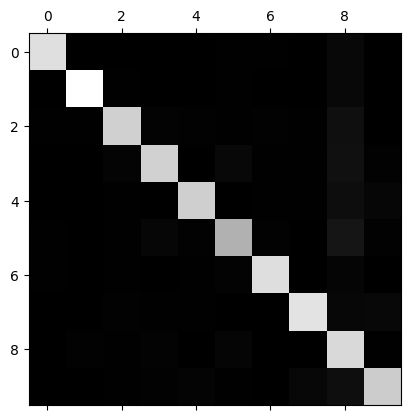

In [48]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

대부분의 이미지가 올바르게 분류되었음을 나타내는 주대각선에 있음 -> 매우 좋음

In [49]:
#오차 행렬의 각 값에 대응되는 클래스의 이미지 개수로 나누어 에러 비율을 비교하기
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

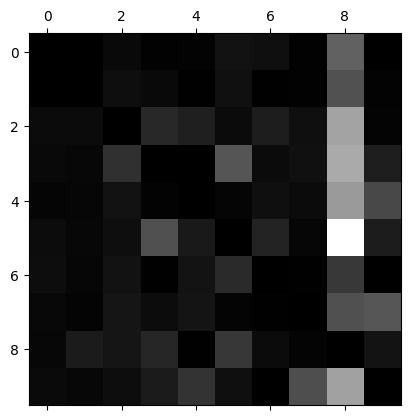

In [59]:
# 다른 항목은 그대로 유지하고 주대각선만 0으로 채워서 그래프 그리기
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

-> 분류기의 성능 향상 방안에 대한 통찰

- 클래스 8의 열이 밝으므로 많은 이미지가 8로 잘못 분류되었음을 알 수 있음
- but 클래스 8의 행을 보면 실제 8이 적절히 8로 분류됨

In [51]:
import matplotlib.pyplot as plt
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = ceil(len(instances) / images_per_row) 와 동일합니다:
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가합니다:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성합니다:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합칩니다.
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합칩니다:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 출력하면 됩니다:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

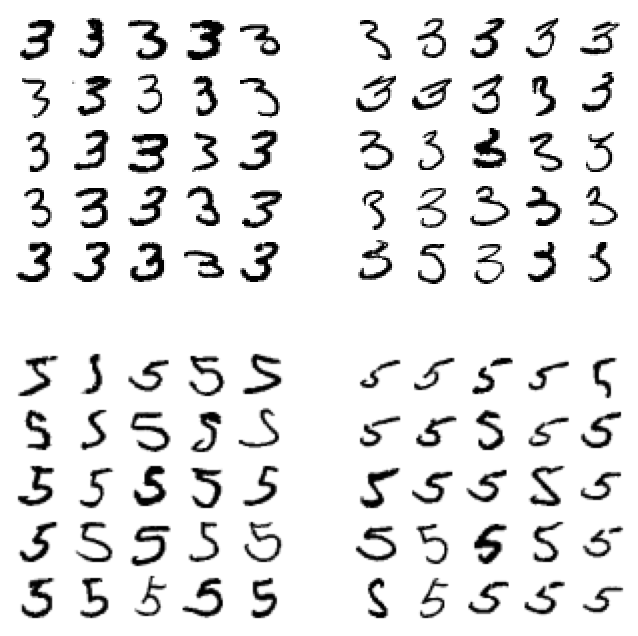

In [52]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train==cl_a) & (y_train_pred==cl_a)]
X_ab = X_train[(y_train==cl_a) & (y_train_pred==cl_b)]
X_ba = X_train[(y_train==cl_b) & (y_train_pred==cl_a)]
X_bb = X_train[(y_train==cl_b) & (y_train_pred==cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

선형 분류기: 클래스마다 픽셀에 가중치를 할당하고 새로운 이미지에 대해 단순히 픽셀 강도의 가중치 합을 클래스의 점수로 계산
-> 선형 모델인 SGDClassifier를 사용하면 몇 개의 픽셀만 다른 3과 5를 쉽게 혼동하게 됨

## 3.6 다중 레이블 분류

- 다중 레이블 분류 : 여러 개의 이진 꼬리표를 출력하는 분류 시스템
- KNeighborsClassifier : 다중 레이블 분류 지원

In [53]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [54]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [55]:
#모든 레이블에 대한 F1 점수의 평균 계산
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

average="weighted" : 레이블에 클래스의 지지도(타깃 레이블에 속한 샘플 수)를 가중치로 주는 방법

## 3.7 다중 출력 분류

다중 출력 (다중 클래스) 분류 : 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것(값을 2개 이상 가질 수 있음)

In [56]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [57]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = plt.cm.binary,
               interpolation="nearest")
    plt.axis("off")

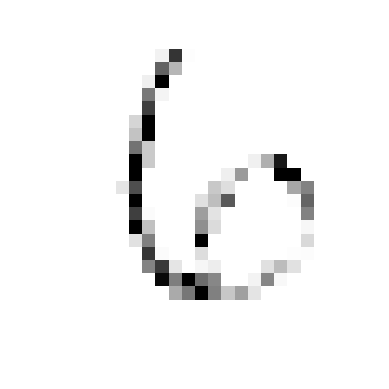

In [58]:
some_index = 100
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

분류기를 훈련시켜 잡음이 섞인 입력 이미지를 깨끗하게 만듦